<a name ="top"></a>
# Welcome to WWPS (What would Presidents say?)!

We have access to all the US Presidential Speeches from April 30th, 1789 to Sept. 25th, 2019. Presidential speeches are an opportunity for Presidents to set the tone of the country, put forth their agenda, influence policy and sway public opinion. This dataset can give us some good insight into what a President would say about various topics. 

# Challenge: Build a pipeline that, when given a sentence, would spit out the top 3 similar sentences previoulsy uttered by different US presidents.


So in other words we're going to create WWPS i.e. "What would Presidents say?" 

Source data: https://www.kaggle.com/littleotter/united-states-presidential-speeches

# Results



### Sentence Embedding Model using SentenceBERT
1. The results were good! The top 3 sentences accurately conveyed the meaning of the input sentence.
    - query = "I believe I our children are our future."
2. The top 3 results gave a **cosine similarity of 0.889 to 0.956**
3. The model took over 24 hours to run. 
4. The long run time of the model prevented further exploration of the model for example with different queries..

### Word Embedding Model using GloVe
1. The results did **not** resemble the query in spite of the soft cosine similarity being 0.982 to 1.0.
    - query = 'I believe that the young people in America are our future.'
2. The model was much less complex.
3. The model did not convey the meaning of the input sentences. 


### Limitations

1. The dataset requires more lot of cleaning.
    - Some was attempted. But for the most part this would require significantly more time

# TABLE OF CONTENTS

[Go to top](#top)

PART A. [EXPLORING THE DATASET](#step0)  
[Step 0: Solution Approach](#stepm)   
[Step i: Import Libraries and Load the Data](#stepi)  
[Step ii: Work with a subset](#stepii)  
[Step iii: Characteristics of the dataset](#stepiii)   
[Step iv: Data Cleaning](#stepiv)

PART B. [SENTENCE EMBEDDING](#stepb)  
1. [Define Cosine Similarity Function](#step1)
2. [SentenceBERT](#step2)
3. [Results](#results_bert)

PART C. [WORD EMBEDDING](#stepc)  
1. [GLoVe](#step3) 
2. [Results](#results_glove)

PART D. LIMITATIONS & REFERENCES  
1. [Limitations](#limitations)
2. [References](#references)

<a name =step0></a>
# PART A - EXPLORING THE DATASET

[Go to top](#top)

<a name =stepm></a>
    
# Step 0: Solution Approach

[Go to top](#top)

#### Understanding the problem
The first thing we need to do is understand the type of problem we are solving. The main features of this problem are:

- Unsupervised Learning
    - The data is not labelled and we don't have a test set to validate our results.
- Text Similarity
    - We need to compare whether one set of text with another and determine their similarity.
- Information Retrieval
    - We need to fetch relevant sources of information from a corpus just like a quer or search on a search engine. Now that we know that we understand which steps to take to develop a suitable algorithm.

#### Text Similarity Approach

There are 2 main ways to analyse Text Similarity; Lexical Similarity and Semantical Similarity. We will select Semantical Similarity as in addition to syntax, the algorithm will consider context.

The steps involved in Text Similarity:

- Information Retrieval
    - We need to define search term(query) and find a way to get input from the user.
- Text Normalization
    - Tokenize the sentences.
    - Develop a method that can be used for both the search_ and the corpus.
- Feature Engineering
    - Our options here include Bag of Words, TF-IDF and Word Vectorization
    - We will use a Word Embebbding Model and a Sentence Embedding Model
- Similarity Measure
    - We need to find an optimal measure.
    - Options include Hellinger-Bhattcharya Distance and Okapi BM25 ranking
    - We will use Soft Cosine Measure

<a name =stepi></a>
    
# Step i: Import Libraries and Load the Data

[Go to top](#top)

In [1]:
#import matplotlib.pyplot as plt
import pandas as pd
import nltk
import re
import numpy as np

from io import StringIO

from nltk import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline

import seaborn as sns
from matplotlib import pyplot as plt

In [7]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [2]:
def read_corpus():
    corpus_df = pd.read_csv('corpus.csv')
    return corpus_df

In [3]:
corpus_df = read_corpus()

In [4]:
corpus_df.iloc[:10]

,Unnamed: 0,Party,transcripts
0,George Washington,Unaffiliated,Fellow Citizens of the Senate and the House of...
1,John Adams,Federalist,"When it was first perceived, in early times, t..."
2,Thomas Jefferson,Democratic-Republican,"FRIENDS AND FELLOW-CITIZENS, Called upon to un..."
3,James Madison,Democratic-Republican,Unwilling to depart from examples of the most ...
4,James Monroe,Democratic-Republican,I should be destitute of feeling if I was not ...
5,John Quincy Adams,Democratic-Republican,"AND NOW, FRIENDS AND COUNTRYMEN, if the wise a..."
6,Andrew Jackson,Democratic,Fellow Citizens: About to undertake the arduou...
7,Martin Van Buren,Democratic,Fellow Citizens: The practice of all my predec...
8,William Harrison,Whig,Called from a retirement which I had supposed ...
9,John Tyler,Unaffiliated,To the People of the United States Before my a...


In [5]:
corpus_df.rename( columns={"Unnamed: 0" :"President"}, inplace=True )
corpus_df.head()

,President,Party,transcripts
0,George Washington,Unaffiliated,Fellow Citizens of the Senate and the House of...
1,John Adams,Federalist,"When it was first perceived, in early times, t..."
2,Thomas Jefferson,Democratic-Republican,"FRIENDS AND FELLOW-CITIZENS, Called upon to un..."
3,James Madison,Democratic-Republican,Unwilling to depart from examples of the most ...
4,James Monroe,Democratic-Republican,I should be destitute of feeling if I was not ...


In [18]:
corpus_df.shape

(44, 3)

<a name =stepii></a>
    
# Step ii:  Work with a subset
To speed up processing

[Go to top](#top)

In [6]:
subset_df = corpus_df.loc[42:43, ("President","transcripts")]
subset_df

,President,transcripts
42,Barack Obama,To Chairman Dean and my great friend Dick Durb...
43,Donald Trump,"Chief Justice Roberts, President Carter, Presi..."


<a name =stepiii></a>
    
# Step iii:  Characteristics of the dataset
Let's examine the length (no. of characters, words and sentences) in each corpora.

[Go to top](#top)

## Length

### Length -  Number of Speeches

Could not easily split into individal speeches.
The empty_tokens found later may be a way to count and number the number of speeches and I dntify them.

### Length by character i.e. letters, spaces and punctuation

In [ ]:
len(subset_df.transcripts.iloc[0])

1155148

In [ ]:
#Includes letters, spaces and punctuation
len('Hi how are you? Do you?')

23

In [ ]:
[len(subset_df.transcripts.iloc[i]) for i in range(subset_df.shape[0])]

[1155148, 475677]

In [ ]:
len_char = [len(corpus_df.transcripts.iloc[i]) for i in range(corpus_df.shape[0])]
len_char

[190015,
 88556,
 211059,
 216989,
 297306,
 222338,
 933812,
 389851,
 49669,
 411510,
 620263,
 68280,
 234451,
 385312,
 485593,
 597666,
 569655,
 621306,
 410483,
 17722,
 305870,
 919540,
 836204,
 566308,
 756190,
 709967,
 490304,
 174762,
 452057,
 546456,
 1166892,
 207143,
 105898,
 698750,
 1421446,
 382082,
 240004,
 588246,
 1188847,
 512239,
 768815,
 630362,
 1155148,
 475677]

#### Plots for Length Total Characters

In [ ]:
corpus_df["characters"] = len_char
corpus_df.head()

,President,Party,transcripts,characters
0,George Washington,Unaffiliated,Fellow Citizens of the Senate and the House of...,190015
1,John Adams,Federalist,"When it was first perceived, in early times, t...",88556
2,Thomas Jefferson,Democratic-Republican,"FRIENDS AND FELLOW-CITIZENS, Called upon to un...",211059
3,James Madison,Democratic-Republican,Unwilling to depart from examples of the most ...,216989
4,James Monroe,Democratic-Republican,I should be destitute of feeling if I was not ...,297306


<AxesSubplot:>

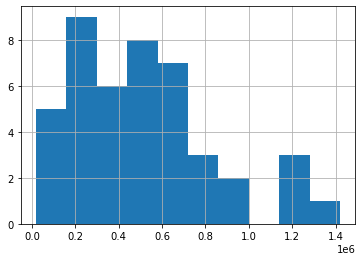

In [ ]:
corpus_df['characters'].hist()

<AxesSubplot:ylabel='characters'>

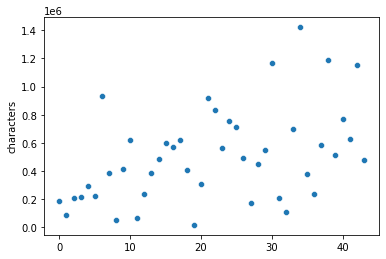

In [ ]:
sns.scatterplot(data=corpus_df, x=corpus_df.index, y="characters")

<a name="words"></a>
### Length by words
Removing punctuation and irrelevant terms where possible as determined in the [Data Cleaning](#stepiv) section below.

In [22]:
len(word_tokenize(subset_df.transcripts.iloc[0]))

232121

In [23]:
#Counts words includes punctation
word_tokenize('Hi how are you? Do you?'), len(word_tokenize('Hi how are you? Do you?'))

(['Hi', 'how', 'are', 'you', '?', 'Do', 'you', '?'], 8)

In [9]:
def clean(doc):
    # Tokenize, clean up input document string
    doc = re.sub(r'\[[^()]*\]',"", doc)#removes [Applause]["Laughter"]
    doc = re.sub(r'\([^()]*\)',"", doc)#removes (Applause)("Laughter")
    doc = re.sub(r'[^\w\s]', "", doc)# removes punctuation
    doc = re.sub(r'\b[A-Z][A-Z0-9]+\b',"",doc) #remove ALL CAPS
    doc=" ".join(doc.split()) #remove double whitespace
    return doc.lower()

In [26]:
clean("Hi how are Cow ; 'you don't' "" THOMAS JEFF you (laughter) [Applause]? Do you?'=") #len(clean('Hi how are Cow THOMAS JEFF you [Applause]? Do you?'))

'hi how are cow you dont you do you'

In [10]:
# remove empty tokens
speeches=(subset_df.transcripts.iloc[0])
words = word_tokenize(speeches)
cleaned_speeches = [clean(speech) for speech in words]
cleanup_tokens = [ tok for tok in cleaned_speeches if tok ]
empty_tokens = [ tok for tok in cleaned_speeches if not tok ]

In [27]:
len(cleaned_speeches), len(cleanup_tokens)

(232121, 207813)

#### Empty Tokens

In [146]:
empty_tokens

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',


### Length by words cont'd

In [11]:
def len_speech(df): 
    length_speeches=[] 
    for i in range(df.shape[0]):
        speeches=(df.transcripts.iloc[i])
        words = word_tokenize(speeches)
        cleaned_speeches = [clean(speech) for speech in words]
        cleanup_tokens = [tok for tok in cleaned_speeches if tok] 
        length_speeches.append(len(cleanup_tokens))
    return length_speeches


In [29]:
length_speeches_pres = len_speech(subset_df)
length_speeches_pres

[207813, 85452]

In [12]:
length_speeches_pres = len_speech(corpus_df)
length_speeches_pres

[31521,
 14653,
 35885,
 36076,
 50197,
 37038,
 158016,
 64877,
 8461,
 69743,
 104737,
 11377,
 39000,
 63465,
 81102,
 103386,
 95429,
 103752,
 67815,
 2978,
 50036,
 150587,
 140194,
 92798,
 132240,
 116406,
 85472,
 28917,
 74147,
 89836,
 197224,
 37078,
 18117,
 122162,
 251584,
 68204,
 40739,
 102470,
 209691,
 91875,
 137663,
 108811,
 207813,
 85453]

In [31]:
len(length_speeches_pres)

44

#### Plots for Length Words

In [13]:
corpus_df["total_words"] = length_speeches_pres
corpus_df.head()

,President,Party,transcripts,total_words
0,George Washington,Unaffiliated,Fellow Citizens of the Senate and the House of...,31521
1,John Adams,Federalist,"When it was first perceived, in early times, t...",14653
2,Thomas Jefferson,Democratic-Republican,"FRIENDS AND FELLOW-CITIZENS, Called upon to un...",35885
3,James Madison,Democratic-Republican,Unwilling to depart from examples of the most ...,36076
4,James Monroe,Democratic-Republican,I should be destitute of feeling if I was not ...,50197


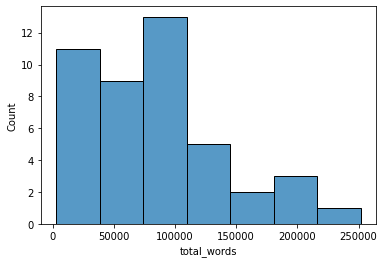

In [157]:
sns.histplot(data=corpus_df, x='total_words')

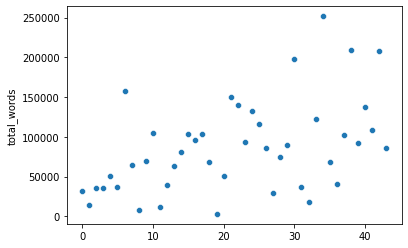

In [158]:
sns.scatterplot(data=corpus_df, x=corpus_df.index, y="total_words")

#### Most used Words by each President
Can be used as a basis for stop words for model

In [14]:
import collections
from collections import Counter

In [15]:
def most_occur(a_list,j): 
  c = Counter(a_list)
  most_occur = c.most_common(j)
  return most_occur

def cleanup_words(df):
  cleanup_token_all=[]  
  for i in range(df.shape[0]):
      speeches=(df.transcripts.iloc[i])
      words = word_tokenize(speeches)
      cleaned_speeches = [clean(speech) for speech in words]
      cleanup_tokens = [tok for tok in cleaned_speeches if tok]
      cleanup_token_all.append(cleanup_tokens) 
  #df["Cleaned Tokens"]=cleanup_token_all
  return cleanup_token_all

def most_common_w(df,j):
  cleaned_words=[]
  for i in range(df.shape[0]): 
    most_common_words=dict(most_occur(cleanup_words(df)[i],j))
    cleaned_words.append(most_common_words)
  df["Cleaned Words"]=cleaned_words
  return df
    



In [34]:
most_common_w(subset_df,100)

,President,transcripts,Cleaned Words
42,Barack Obama,To Chairman Dean and my great friend Dick Durb...,"{'the': 9491, 'and': 7277, 'to': 6763, 'of': 5..."
43,Donald Trump,"Chief Justice Roberts, President Carter, Presi...","{'the': 3456, 'and': 3309, 'to': 2543, 'we': 2..."


In [16]:
most_common_w(corpus_df,100)

,President,Party,transcripts,total_words,Cleaned Words
0,George Washington,Unaffiliated,Fellow Citizens of the Senate and the House of...,31521,"{'the': 2698, 'of': 1883, 'to': 1328, 'and': 1..."
1,John Adams,Federalist,"When it was first perceived, in early times, t...",14653,"{'the': 1244, 'of': 914, 'and': 640, 'to': 553..."
2,Thomas Jefferson,Democratic-Republican,"FRIENDS AND FELLOW-CITIZENS, Called upon to un...",35885,"{'the': 2663, 'of': 1940, 'to': 1389, 'and': 1..."
3,James Madison,Democratic-Republican,Unwilling to depart from examples of the most ...,36076,"{'the': 3613, 'of': 2308, 'and': 1275, 'to': 1..."
4,James Monroe,Democratic-Republican,I should be destitute of feeling if I was not ...,50197,"{'the': 4688, 'of': 2709, 'to': 1890, 'and': 1..."
5,John Quincy Adams,Democratic-Republican,"AND NOW, FRIENDS AND COUNTRYMEN, if the wise a...",37038,"{'the': 4010, 'of': 3109, 'to': 1244, 'and': 1..."
6,Andrew Jackson,Democratic,Fellow Citizens: About to undertake the arduou...,158016,"{'the': 15572, 'of': 9439, 'to': 6253, 'and': ..."
7,Martin Van Buren,Democratic,Fellow Citizens: The practice of all my predec...,64877,"{'the': 6129, 'of': 3962, 'to': 2444, 'and': 2..."
8,William Harrison,Whig,Called from a retirement which I had supposed ...,8461,"{'the': 829, 'of': 604, 'to': 318, 'and': 231,..."
9,John Tyler,Unaffiliated,To the People of the United States Before my a...,69743,"{'the': 6870, 'of': 4452, 'to': 2789, 'and': 2..."


#### Most used Words by all President
Shall be used as stop words for model

In [17]:
import functools, operator
most_common_sum = dict(functools.reduce(operator.add,
         map(collections.Counter, corpus_df["Cleaned Words"])))

stop_words_real =most_common_sum

stop_words_sorted = sorted(stop_words_real.items(), key=lambda kv: kv[1], reverse=True)
stop_words_sorted[:100]


[('the', 295710),
 ('of', 186742),
 ('and', 130829),
 ('to', 129621),
 ('in', 81502),
 ('a', 62747),
 ('that', 58416),
 ('is', 39010),
 ('be', 37900),
 ('for', 37775),
 ('it', 36836),
 ('we', 35989),
 ('our', 34063),
 ('i', 31620),
 ('have', 28478),
 ('by', 27973),
 ('this', 27816),
 ('as', 26032),
 ('with', 24308),
 ('not', 23023),
 ('which', 21524),
 ('are', 21064),
 ('will', 20755),
 ('on', 20122),
 ('has', 16800),
 ('their', 16472),
 ('all', 16296),
 ('or', 15955),
 ('been', 15752),
 ('from', 15414),
 ('but', 14664),
 ('they', 14471),
 ('at', 13673),
 ('was', 13588),
 ('states', 13147),
 ('you', 12214),
 ('government', 12212),
 ('an', 12146),
 ('can', 11513),
 ('people', 11298),
 ('united', 10125),
 ('its', 9665),
 ('would', 9490),
 ('who', 9155),
 ('so', 9138),
 ('more', 9108),
 ('these', 8947),
 ('no', 8850),
 ('s', 8754),
 ('there', 8491),
 ('them', 8304),
 ('if', 7840),
 ('any', 7544),
 ('other', 7448),
 ('congress', 7386),
 ('should', 7362),
 ('now', 7328),
 ('do', 7189),
 ('t

In [18]:
def stops_used(m):
  stop_words_used=[]
  for item in stop_words_sorted:
    if item[1]>m:
      stop_words_used.append(item[0])
  return(stop_words_used)

len(stops_used(10000)), len(stops_used(6000)), stops_used(6000) 

(41,
 67,
 ['the',
  'of',
  'and',
  'to',
  'in',
  'a',
  'that',
  'is',
  'be',
  'for',
  'it',
  'we',
  'our',
  'i',
  'have',
  'by',
  'this',
  'as',
  'with',
  'not',
  'which',
  'are',
  'will',
  'on',
  'has',
  'their',
  'all',
  'or',
  'been',
  'from',
  'but',
  'they',
  'at',
  'was',
  'states',
  'you',
  'government',
  'an',
  'can',
  'people',
  'united',
  'its',
  'would',
  'who',
  'so',
  'more',
  'these',
  'no',
  's',
  'there',
  'them',
  'if',
  'any',
  'other',
  'congress',
  'should',
  'now',
  'do',
  'those',
  'one',
  'country',
  'than',
  'such',
  'upon',
  'my',
  'were',
  'time'])

## No. of Sentences
1. Normalize text (No. of sentences)
2. No. of unique sentences
3. Most used/repeated sentences

<a name="normalize"></a>
#### 1. Normalize text
Start with a subset again

In [ ]:
from re import sub
#gensim simple_preprocess - This lowercases, tokenizes, removes punctuation, de-accents (optional). 
from gensim.utils import simple_preprocess

speeches=(subset_df.transcripts.iloc[0])
sentences=sent_tokenize(speeches)
president =subset_df.President.iloc[0]
president, sentences

('Barack Obama',
 ['To Chairman Dean and my great friend Dick Durbin; and to all my fellow citizens of this great nation; With profound gratitude and great humility, I accept your nomination for the presidency of the United States.',
  'Let me express my thanks to the historic slate of candidates who accompanied me on this journey, and especially the one who traveled the farthest, a champion for working Americans and an inspiration to my daughters and to yours, Hillary Rodham Clinton.',
  'To President Clinton, who last night made the case for change as only he can make it; to Ted Kennedy, who embodies the spirit of service; and to the next Vice President of the United States, Joe Biden, I thank you.',
  'I am grateful to finish this journey with one of the finest statesmen of our time, a man at ease with everyone from world leaders to the conductors on the Amtrak train he still takes home every night.',
  'To the love of my life, our next First Lady, Michelle Obama, and to Sasha and M

In [ ]:
len(sentences)

10672

In [ ]:
len_sentences=[]
for i in range(corpus_df.shape[0]):
    speeches = (corpus_df.transcripts.iloc[i])
    sentences=sent_tokenize(speeches)
    len(sentences)
    len_sentences.append(len(sentences))
len_sentences

[786,
 363,
 938,
 711,
 1385,
 878,
 3700,
 1530,
 206,
 1792,
 2692,
 275,
 1008,
 1464,
 2459,
 3951,
 2532,
 2870,
 1865,
 108,
 1540,
 4202,
 4189,
 2841,
 5519,
 3384,
 2691,
 1189,
 3382,
 3521,
 6457,
 1917,
 809,
 4768,
 12715,
 2802,
 2023,
 5345,
 10300,
 5536,
 6695,
 5939,
 10672,
 6276]

In [ ]:
corpus_df["len_sentences"] = len_sentences
corpus_df.head()

,President,Party,transcripts,characters,total_words,len_sentences
0,George Washington,Unaffiliated,Fellow Citizens of the Senate and the House of...,190015,31502,786
1,John Adams,Federalist,"When it was first perceived, in early times, t...",88556,14630,363
2,Thomas Jefferson,Democratic-Republican,"FRIENDS AND FELLOW-CITIZENS, Called upon to un...",211059,35823,938
3,James Madison,Democratic-Republican,Unwilling to depart from examples of the most ...,216989,35991,711
4,James Monroe,Democratic-Republican,I should be destitute of feeling if I was not ...,297306,49931,1385


<AxesSubplot:xlabel='len_sentences', ylabel='Count'>

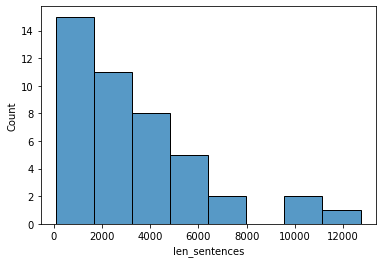

In [ ]:
sns.histplot(data=corpus_df, x='len_sentences')

<AxesSubplot:>

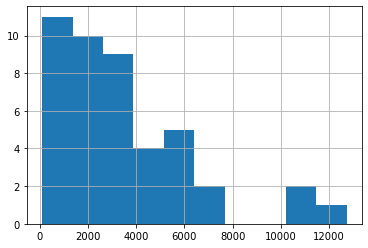

In [ ]:
corpus_df['len_sentences'].hist()

<AxesSubplot:ylabel='len_sentences'>

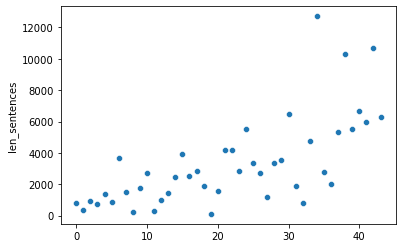

In [ ]:
sns.scatterplot(data=corpus_df, x=corpus_df.index, y="len_sentences")

#### 2. No. of Unique Sentences

Remove duplicate sentences to save computing time later on.

In [ ]:
unique_sentences = list(dict.fromkeys(sentences))

In [ ]:
len(sentences),len(unique_sentences)

(6276, 5962)

In [ ]:
unique_sentences

['Chief Justice Roberts, President Carter, President Clinton, President Bush, President Obama, fellow Americans, and people of the world: thank you.',
 'We, the citizens of America, are now joined in a great national effort to rebuild our country and to restore its promise for all of our people.',
 'Together, we will determine the course of America and the world for years to come.',
 'We will face challenges.',
 'We will confront hardships.',
 'But we will get the job done.',
 'Every four years, we gather on these steps to carry out the orderly and peaceful transfer of power, and we are grateful to President Obama and First Lady Michelle Obama for their gracious aid throughout this transition.',
 'They have been magnificent.',
 "Today's ceremony, however, has very special meaning.",
 'Because today we are not merely transferring power from one Administration to another, or from one party to another – but we are transferring power from Washington, D.C. and giving it back to you, the Ame

In [ ]:
len_unique_sentences=[]
for i in range(corpus_df.shape[0]):
    speeches = (corpus_df.transcripts.iloc[i])
    sentences=sent_tokenize(speeches)
    unique_sentences = list(dict.fromkeys(sentences))
    len(unique_sentences)
    len_unique_sentences.append(len(unique_sentences))
len_unique_sentences

[786,
 361,
 938,
 708,
 1385,
 878,
 3693,
 1528,
 206,
 1772,
 2681,
 275,
 1007,
 1463,
 2446,
 2934,
 2469,
 2798,
 1837,
 108,
 1539,
 4029,
 2522,
 2825,
 5508,
 3292,
 2508,
 1161,
 3382,
 3468,
 6292,
 1916,
 799,
 4630,
 10372,
 2801,
 2023,
 4846,
 9717,
 5008,
 6630,
 5880,
 10386,
 5962]

In [ ]:
corpus_df["unique_sentences"] = len_unique_sentences
corpus_df.head()

,President,Party,transcripts,characters,total_words,len_sentences,unique_sentences
0,George Washington,Unaffiliated,Fellow Citizens of the Senate and the House of...,190015,31502,786,786
1,John Adams,Federalist,"When it was first perceived, in early times, t...",88556,14630,363,361
2,Thomas Jefferson,Democratic-Republican,"FRIENDS AND FELLOW-CITIZENS, Called upon to un...",211059,35823,938,938
3,James Madison,Democratic-Republican,Unwilling to depart from examples of the most ...,216989,35991,711,708
4,James Monroe,Democratic-Republican,I should be destitute of feeling if I was not ...,297306,49931,1385,1385


<AxesSubplot:xlabel='unique_sentences', ylabel='Count'>

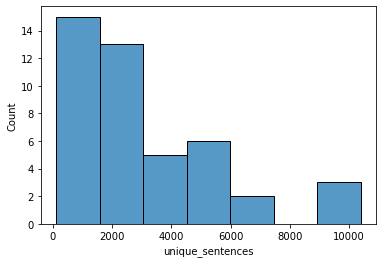

In [ ]:
sns.histplot(data=corpus_df, x='unique_sentences')

<AxesSubplot:ylabel='unique_sentences'>

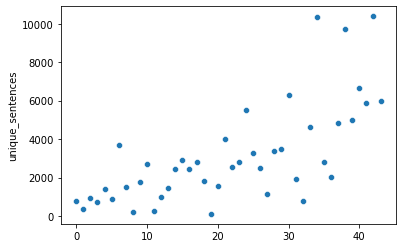

In [ ]:
sns.scatterplot(data=corpus_df, x=corpus_df.index, y="unique_sentences")

#### 3. Most used sentences by each president 

This was included as an interesting output. Instead it revealed the data included irrelevant data like crowd response:
- Laughter, Applause
- The names of the Presidents att the end of their speech
- number indices (bullet) points. e.g. 2.
- The President / THE PRESIDENT

In [ ]:
import collections

def max_frequency(a_list):
    frequency = collections.Counter(a_list)
    return max(dict(frequency), key=dict(frequency).get), max(dict(frequency).values())


random_list = ['A', 'A', 'B', 'C', 'B', 'D', 'D']
max_frequency(random_list)

('A', 2)

In [ ]:
max_frequency(sentences)

('Thank you.', 65)

In [ ]:
max_frequency(sentences)[1]

65

In [ ]:
most_common_sent=[]
frequency_sent = []
for i in range(corpus_df.shape[0]):
    speeches = (corpus_df.transcripts.iloc[i])
    sentences=sent_tokenize(speeches)
    most_common_sent.append(max_frequency(sentences)[0])
    frequency_sent.append(max_frequency(sentences)[1])
most_common_sent, frequency_sent


(['Fellow Citizens of the Senate and the House of Representatives: Among the vicissitudes incident to life, no event could have filled me with greater anxieties than that of which the notification was transmitted by your order, and received on the fourteenth day of the present month.',
  'JOHN ADAMS.',
  'FRIENDS AND FELLOW-CITIZENS, Called upon to undertake the duties of the first executive office of our country, I avail myself of the presence of that portion of my fellow citizens which is here assembled to express my grateful thanks for the favor with which they have been pleased to look toward me, to declare a sincere consciousness that the task is above my talents, and that I approach it with those anxious and awful presentiments which the greatness of the charge and the weakness of my powers so justly inspire.',
  'JAMES MADISON.',
  'I should be destitute of feeling if I was not deeply affected by the strong proof which my fellow citizens have given me of their confidence in call

In [ ]:
corpus_df["most_spoken_sentence"] = most_common_sent 
corpus_df["freqency_max_sent"] = frequency_sent
corpus_df

,President,Party,transcripts,characters,total_words,len_sentences,unique_sentences,most_spoken_sentence,freqency_max_sent
0,George Washington,Unaffiliated,Fellow Citizens of the Senate and the House of...,190015,31502,786,786,Fellow Citizens of the Senate and the House of...,1
1,John Adams,Federalist,"When it was first perceived, in early times, t...",88556,14630,363,361,JOHN ADAMS.,3
2,Thomas Jefferson,Democratic-Republican,"FRIENDS AND FELLOW-CITIZENS, Called upon to un...",211059,35823,938,938,"FRIENDS AND FELLOW-CITIZENS, Called upon to un...",1
3,James Madison,Democratic-Republican,Unwilling to depart from examples of the most ...,216989,35991,711,708,JAMES MADISON.,3
4,James Monroe,Democratic-Republican,I should be destitute of feeling if I was not ...,297306,49931,1385,1385,I should be destitute of feeling if I was not ...,1
5,John Quincy Adams,Democratic-Republican,"AND NOW, FRIENDS AND COUNTRYMEN, if the wise a...",222338,36522,878,878,"AND NOW, FRIENDS AND COUNTRYMEN, if the wise a...",1
6,Andrew Jackson,Democratic,Fellow Citizens: About to undertake the arduou...,933812,157443,3700,3693,"As, then, the period approaches when the appli...",2
7,Martin Van Buren,Democratic,Fellow Citizens: The practice of all my predec...,389851,64664,1530,1528,M. VAN BUREN.,3
8,William Harrison,Whig,Called from a retirement which I had supposed ...,49669,8461,206,206,Called from a retirement which I had supposed ...,1
9,John Tyler,Unaffiliated,To the People of the United States Before my a...,411510,69398,1792,1772,No.,17


<a name =stepiv></a>
    
# Step iv:  Data Cleaning
Based on findings in the Data Exploration we will remove:

- Laughter, Applause
- The names of the Presidents at the end of their speech
- number indices (bullet) points. e.g. 2.
- The President / THE PRESIDENT

[Go to top](#top)

<a name = "further_cleaning"></a>
### The following will be removed from the Speaches: 

- Square brackets and Parenthsis and everything inside them.
    - [ Laughter ], 
    - [ Laughter. ] 
    - [ Applause ] 
    - [ applause ]


- Removing ALL WORDS IN ALL CAPS:
    - The following names: written in ALL CAPS "JOHN ADAMS", "JAMES MADISON" etc.
    - will lose some relevant data like: "FRIENDS AND FELLOW-CITIZENS" by Thomas Jefferson and AND NOW, FRIENDS AND COUNTRYMEN by John Quincy Adams
    

- Will **not** remove:
   - "Second." is valid language usage by Taft and Chester A Arthur
   - Grover Clevland used "2." a lot - in itemizing and references to money. A lot of his figures ended in 20cents! The simple_tokenization by gensim being used removes numbers.
   

### Further Cleaning is required: 
   - Stating the date and location speech was given. Often preceeded by "JOHN ADAMS" -type terms e.g.
        - "Given at Washington, this 23d day of July, A. D. 1813. "
        - "Done at the city of Washington, the 1st day of September, A.D. 1814, and of the Independence of the United States the thirty ninth."
   - There are telegrams within Theodore Rooselvelt's Speech that need to be removed.
   - There may be similar correspondence like this in other copora. Further review required. 
   - I didn't take out proper nouns because of nature of text. But may need to reconsider.

The following preprocessing function was used to create the clean function in the [Number of words](#words) section and the preprocessing in the [normalize text](#normalize) section.

In [19]:
def clean_sent(doc):
    # Tokenize, clean up input document string
    doc = re.sub(r'\[[^()]*\]',"", doc)#removes [Applause]["Laughter"]
    doc = re.sub(r'\([^()]*\)',"", doc)#removes (Applause)("Laughter")
    doc = re.sub(r'[^\w\s]', "", doc)# removes punctuation
    doc = re.sub(r'\b[A-Z][A-Z0-9]+\b',"",doc) #remove ALL CAPS
    doc=" ".join(doc.split()) #remove double whitespace
    return doc.lower()
    #return [token for token in simple_preprocess(doc, min_len=0, max_len=float("inf"))] #used for Gensim model

In [20]:
#remove stop words
stopwords = stops_used(8500)

def remove_stop_words(doc):
    removed_stop_words = []
    for tok_sent in doc:
        removed_stop_words.append(
            ' '.join([word for word in tok_sent.split() 
                      if word not in stopwords])
        )
    return removed_stop_words



In [21]:
def get_stemmed_text(doc):
    from nltk.stem.porter import PorterStemmer
    stemmer = PorterStemmer()
    return [' '.join([stemmer.stem(word) for word in tok_sent.split()]) for tok_sent in doc]



In [22]:
def get_lemmatized_text(doc):
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    return [' '.join([lemmatizer.lemmatize(word) for word in tok_sent.split()]) for tok_sent in doc]



#### Testing Text Processing and Normalization
- did not do stemming

In [ ]:
# sentence tokenize and remove empty tokens
speeches=(subset_df.transcripts.iloc[0])
sentences = sent_tokenize(speeches)
cleaned_speeches = [clean_sent(speech) for speech in sentences]
cleanup_sentences = [ sent for sent in cleaned_speeches if sent ]
empty_sentences = [ sent for sent in cleaned_speeches if not sent ]

In [383]:
#stopwords

In [384]:
#"stops_used(6000)"
#len(cleanup_sentences[7]), cleanup_sentences[7] ,len(cleanup_sentences[55]), cleanup_sentences[55] ,len(cleanup_sentences[100]), cleanup_sentences[100]

In [385]:
#"stops_used(10000)"
len(cleanup_sentences[7]), cleanup_sentences[7] ,len(cleanup_sentences[55]), cleanup_sentences[55] ,len(cleanup_sentences[100]), cleanup_sentences[100]

(142,
 'no people can be bound to acknowledge and adore the invisible hand which conducts the affairs of men more than the people of the united states',
 339,
 'since your last sessions i have received communications by which it appears that the district of kentucky at present a part of virginia has concurred in certain propositions contained in a law of that state in consequence of which the district is to become a distinct member of the union in case the requisite sanction of congress be added',
 111,
 'but it does not appear from any proofs yet in the possession of government that oliver phelps has defrauded you')

In [386]:
#"stops_used(6000)"
#no_stop_words = remove_stop_words(cleanup_sentences)
len(no_stop_words[7]), no_stop_words[7],len(no_stop_words[55]), no_stop_words[55],len(no_stop_words[100]), no_stop_words[100]

(64,
 'bound acknowledge adore invisible hand conducts affairs men than',
 236,
 'since your last sessions received communications appears district kentucky present part virginia concurred certain propositions contained law state consequence district become distinct member union case requisite sanction congress added',
 61,
 'does appear any proofs yet possession oliver phelps defrauded')

In [387]:
#"stops_used(10000)"
no_stop_words = remove_stop_words(cleanup_sentences)
len(no_stop_words[7]), no_stop_words[7],len(no_stop_words[55]), no_stop_words[55],len(no_stop_words[100]), no_stop_words[100]

(64,
 'bound acknowledge adore invisible hand conducts affairs men than',
 236,
 'since your last sessions received communications appears district kentucky present part virginia concurred certain propositions contained law state consequence district become distinct member union case requisite sanction congress added',
 61,
 'does appear any proofs yet possession oliver phelps defrauded')

In [388]:
#8000
stemmed_speech = get_stemmed_text(no_stop_words)
len(stemmed_speech[7]), stemmed_speech[7],len(stemmed_speech[55]), stemmed_speech[55],len(stemmed_speech[100]), stemmed_speech[100]

(56,
 'bound acknowledg ador invis hand conduct affair men than',
 205,
 'sinc your last session receiv commun appear district kentucki present part virginia concur certain proposit contain law state consequ district becom distinct member union case requisit sanction congress ad',
 51,
 'doe appear ani proof yet possess oliv phelp defraud')

In [389]:
#"stops_used(6000)"
#lemmatized_speech = get_lemmatized_text(no_stop_words)
len(lemmatized_speech[7]),lemmatized_speech[7],len(lemmatized_speech[55]),lemmatized_speech[55],len(lemmatized_speech[100]),lemmatized_speech[100]

(62,
 'bound acknowledge adore invisible hand conduct affair men than',
 233,
 'since your last session received communication appears district kentucky present part virginia concurred certain proposition contained law state consequence district become distinct member union case requisite sanction congress added',
 59,
 'doe appear any proof yet possession oliver phelps defrauded')

In [390]:
#"stops_used(8000)"
lemmatized_speech = get_lemmatized_text(stemmed_speech)
len(lemmatized_speech[7]),lemmatized_speech[7],len(lemmatized_speech[55]),lemmatized_speech[55],len(lemmatized_speech[100]),lemmatized_speech[100]

(56,
 'bound acknowledg ador invis hand conduct affair men than',
 205,
 'sinc your last session receiv commun appear district kentucki present part virginia concur certain proposit contain law state consequ district becom distinct member union case requisit sanction congress ad',
 49,
 'doe appear ani proof yet posse oliv phelp defraud')

In [392]:
#cleanup_sentences
#empty_sentences

In [394]:
# remove stop words
#no_stop_words = remove_stop_words(cleanup_sentences)
# lemmatization
#lemmatized_speech = get_lemmatized_text(no_stop_words)


#### Choosing initial stopwords for sentenceBERT as those appearing >8000. times in the corpora. Will apply lemmatzation (not stemming)

In [23]:
transcripts_new=[]
for i in range(corpus_df.shape[0]): #corpus_df.shape[0]
    speeches=(corpus_df.transcripts.iloc[i])
    sentences=sent_tokenize(speeches)
    unique_sentences = list(dict.fromkeys(sentences))
    cleaned_speeches = [clean_sent(speech) for speech in unique_sentences]
    cleanup_sentences = [sent for sent in cleaned_speeches if sent] #remove empty sentences
    no_stop_words=remove_stop_words(cleanup_sentences)
    lemmatized_speech = get_lemmatized_text(no_stop_words)
    transcripts_new.append(lemmatized_speech)
transcripts_new
corpus_df["transcripts_new"]=transcripts_new

In [ ]:
#corpus_df.transcripts.iloc[1] #JOHN ADAMS
#corpus_df.transcripts.iloc[21]

In [105]:
corpus_df

,President,Party,transcripts,Cleaned Words,transcripts_new,Unique Sentences
0,George Washington,Unaffiliated,Fellow Citizens of the Senate and the House of...,"{'the': 2698, 'of': 1883, 'to': 1328, 'and': 1...",[fellow citizen senate house representative am...,[Fellow Citizens of the Senate and the House o...
1,John Adams,Federalist,"When it was first perceived, in early times, t...","{'the': 1244, 'of': 914, 'and': 640, 'to': 553...",[when first perceived early time middle course...,"[When it was first perceived, in early times, ..."
2,Thomas Jefferson,Democratic-Republican,"FRIENDS AND FELLOW-CITIZENS, Called upon to un...","{'the': 2663, 'of': 1940, 'to': 1389, 'and': 1...",[called upon undertake duty first executive of...,"[FRIENDS AND FELLOW-CITIZENS, Called upon to u..."
3,James Madison,Democratic-Republican,Unwilling to depart from examples of the most ...,"{'the': 3613, 'of': 2308, 'and': 1275, 'to': 1...",[unwilling depart example most revered authori...,[Unwilling to depart from examples of the most...
4,James Monroe,Democratic-Republican,I should be destitute of feeling if I was not ...,"{'the': 4688, 'of': 2709, 'to': 1890, 'and': 1...",[should destitute feeling if deeply affected s...,[I should be destitute of feeling if I was not...
5,John Quincy Adams,Democratic-Republican,"AND NOW, FRIENDS AND COUNTRYMEN, if the wise a...","{'the': 4010, 'of': 3109, 'to': 1244, 'and': 1...",[if wise learned philosopher elder world first...,"[AND NOW, FRIENDS AND COUNTRYMEN, if the wise ..."
6,Andrew Jackson,Democratic,Fellow Citizens: About to undertake the arduou...,"{'the': 15572, 'of': 9439, 'to': 6253, 'and': ...",[fellow citizen about undertake arduous duty a...,[Fellow Citizens: About to undertake the arduo...
7,Martin Van Buren,Democratic,Fellow Citizens: The practice of all my predec...,"{'the': 6129, 'of': 3962, 'to': 2444, 'and': 2...",[fellow citizen practice my predecessor impose...,[Fellow Citizens: The practice of all my prede...
8,William Harrison,Whig,Called from a retirement which I had supposed ...,"{'the': 829, 'of': 604, 'to': 318, 'and': 231,...",[called retirement had supposed continue resid...,[Called from a retirement which I had supposed...
9,John Tyler,Unaffiliated,To the People of the United States Before my a...,"{'the': 6870, 'of': 4452, 'to': 2789, 'and': 2...",[before my arrival seat painful communication ...,[To the People of the United States Before my ...


<a name =stepb></a>
    
# PART B: SENTENCE EMBEDDING

[Go to top](#top)


<a name =step1></a>
    
# 1. Define Cosine Similarity Function 

[Go to top](#top)

Source: https://www.analyticsvidhya.com/blog/2020/08/top-4-sentence-embedding-techniques-using-python/

In [24]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

<a name =step2></a>
    
# 2. SentenceBERT 

[Go to top](#top)


In [49]:
!pip install sentence-transformers

     |████████████████████████████████| 79 kB 7.0 MB/s 
     |████████████████████████████████| 3.5 MB 33.7 MB/s 
     |████████████████████████████████| 1.2 MB 50.0 MB/s 
     |████████████████████████████████| 67 kB 5.6 MB/s 
     |████████████████████████████████| 895 kB 48.6 MB/s 
     |████████████████████████████████| 596 kB 49.7 MB/s 
     |████████████████████████████████| 6.8 MB 47.9 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=b637901228274e7f88b493b98a4750b5f4f9230c0cbbda755853a3c0c8f3eeee
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


### Step 1 - Load the pre-trained BERT model. 

There are many other pre-trained models available. You can find the full list of models here. https://github.com/UKPLab/sentence-transformers/blob/master/docs/pretrained-models/sts-models.md

In [25]:
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

### Step 2 - Encode sentences from existing corpus. 

We can also display the sentence vectors(just uncomment the code below)

my cleaned/pre-tokenized data was not accepted by sentenceBERT:  
cleaned_transcripts = corpus_df["transcripts_new"]


Dataset to be used:  
for i in range(corpus_df.shape[0]):
    speeches = corpus_df.transcripts.iloc[i]
    sentences=sent_tokenize(speeches)
    unique_sentences = list(dict.fromkeys(sentences))

#### Let's try for 1 president

In [50]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [26]:
cleaned_transcripts=corpus_df["transcripts_new"]

In [27]:
sentence_embeddings = sbert_model.encode(cleaned_transcripts[0])

In [ ]:
print('Sample BERT embedding vector - length', len(sentence_embeddings[0]))
print('Sample BERT embedding vector - note includes negative values', sentence_embeddings[0])

### Step 3 - Define a test query and encode it as well

In [28]:
query = "I believe I our children are our future."
query_clean=clean_sent(query)
query_ls=[]
query_ls.append(query_clean)                 
query_stop_words=remove_stop_words(query_ls)
query_lemmatized=get_lemmatized_text(query_stop_words)
query_lemmatized


['believe child future']

In [29]:
query_vec = sbert_model.encode([query_lemmatized[0]])[0]

### Step 4 - Compute the cosine similarity using scipy. 

We will retrieve the similarity values between the sentences and our test query:

In [30]:
sim_dict={}
for sent in cleaned_transcripts[0]:
    sim = cosine(query_vec, sbert_model.encode([sent])[0])
    sim_dict[sent]=sim

In [31]:
max_key = max(sim_dict, key=sim_dict.get)
max_value = max(sim_dict.values())
max_key, max_value

('event answered hope', 0.7147625)

### Step 5 - Let's do it for ALL Presidents. 

In [32]:
unique_sent=[]
for i in range(corpus_df.shape[0]): #corpus_df.shape[0]
    speeches=(corpus_df.transcripts.iloc[i])
    sentences=sent_tokenize(speeches)
    unique_sentences = list(dict.fromkeys(sentences))
    unique_sent.append(unique_sentences)
unique_sent
corpus_df["Unique Sentences"]=unique_sent


In [33]:
matching_sent=corpus_df["Unique Sentences"]

In [109]:
matching_sent[1][5]

'Negligence of its regulations, inattention to its recommendations, if not disobedience to its authority, not only in individuals but in States, soon appeared with their melancholy consequences?'

In [112]:
corpus_df.shape[0]

44

<a name =results_bert></a>
### Step 6: Results SentenceBERT
[Go to top](#top)

In [34]:
top_matches = pd.DataFrame()
similar_dict = {}

#For each president:
for i in range(corpus_df.shape[0]):
    sentence_embeddings = sbert_model.encode(cleaned_transcripts[i])
    sim_dict={}
    match_dict={}
    count=0
    for sent in cleaned_transcripts[i]:
      count+=1
      matching_sentence = matching_sent[i][count-1]
      match_dict[sent]= matching_sentence
      sim = cosine(query_vec, sbert_model.encode([sent])[0])
      sim_dict[sent]=sim
    max_key = max(sim_dict, key=sim_dict.get)
    max_value = max(sim_dict.values())
    max_match = match_dict.get(max_key)
    president = corpus_df.President.iloc[i]
    similar_dict = {'President': president, 'Matching Sentence': max_match, 'Normalized Text': max_key, 'Cosine Similarity': max_value}
    top_matches = top_matches.append(similar_dict, ignore_index = True)

top=top_matches.sort_values(by=['Cosine Similarity'], ascending=False)
top

,President,Matching Sentence,Normalized Text,Cosine Similarity
40,Bill Clinton,We will give these children a future.,give child future,0.955503
42,Barack Obama,"Each day, we send nearly $ 1 billion of our we...",consign child future,0.952316
33,John F. Kennedy,For we are both devoting massive sums of money...,cherish childrens future,0.889300
38,Ronald Reagan,It is also the story of how her son secretly v...,let u remember child future want them,0.886800
43,Donald Trump,Believe in your future.,believe your future,0.869568
24,Franklin D. Roosevelt,That is our hope for the future.,hope future,0.845189
41,George W. Bush,And they remind us that we're tied together in...,future come,0.839028
39,George H. W. Bush,They talked about posterity.,talked about future,0.830629
29,Herbert Hoover,Much of it is of interest only to history.,interest now future,0.821938
37,Jimmy Carter,Doesn't this raise a serious question as to wh...,believe good indication kind choose future,0.821646


<a name =stepc></a>
    
# PART C: WORD EMBEDDING

[Go to top](#top)


<a name =step3></a>
    
# 1. GLoVe

[Go to top](#top)

### Step 1: Feature Engineering

In [ ]:
import gensim.downloader as api
glove = api.load("glove-wiki-gigaword-50")  

In [ ]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.models import WordEmbeddingSimilarityIndex
from gensim.similarities import SparseTermSimilarityMatrix
from gensim.similarities import SoftCosineSimilarity

  
similarity_index = WordEmbeddingSimilarityIndex(glove)

# Build the term dictionary, TF-idf model
dictionary = Dictionary(corpus+[query])
tfidf = TfidfModel(dictionary=dictionary)


# Create the term similarity matrix.  
similarity_matrix = SparseTermSimilarityMatrix(similarity_index, dictionary, tfidf)

### Step 2: Soft Cosine Similarity 

[Go to top](#top)

In [ ]:
import numpy as np
# Compute Soft Cosine Measure between the query and the documents.
# From: https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/soft_cosine_tutorial.ipynb
query_tf = tfidf[dictionary.doc2bow(query)]

index = SoftCosineSimilarity(
            tfidf[[dictionary.doc2bow(sentence) for sentence in corpus]],
            similarity_matrix)

doc_similarity_scores = index[query_tf]

# Output the sorted similarity scores and documents
sorted_indexes = np.argsort(doc_similarity_scores)[::-1] #[::-1] Start at the end, end when it ends, end when nothing's left and walk backwards by 1. 
idx = sorted_indexes[0]
print(f'{idx} \t {doc_similarity_scores[idx]:0.3f} \t {sentences[idx]}')

6 	 0.804 	 In tendering this homage to the Great Author of every public and private good, I assure myself that it expresses your sentiments not less than my own; nor those of my fellow citizens at large, less than either.


### Step 3: Apply to entire Dataframe 

[Go to top](#top)

#### Trial 3 b - Added stop words and more descriptive query 

In [ ]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

# From: https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/soft_cosine_tutorial.ipynb
def preprocess(doc):
    # Tokenize, clean up input document string
    doc = sub(r'<img[^<>]+(>|$)', " image_token ", doc)
    doc = sub(r'<[^<>]+(>|$)', " ", doc)
    #doc = sub(r'\[img_assist[^]]*?\]', " ", doc)
    doc = sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', " url_token ", doc)
    return [token for token in simple_preprocess(doc, min_len=0, max_len=float("inf")) if token not in stopwords]

In [ ]:
#terms not loop dependent
query = preprocess('I believe that the young people in America are our future.')
similarity_index = WordEmbeddingSimilarityIndex(glove)
top_matches = pd.DataFrame()
for i in range(0,corpus_df.shape[0]): #
    speeches=(corpus_df.transcripts[i])
    sentences=sent_tokenize(speeches)
    president =corpus_df.President[i]
    # STEP 2 -TEXT NORMALIZATION
    # Preprocess the documents, including the query string
    corpus = [preprocess(sentence) for sentence in sentences] 
    # STEP 3 - FEATURE ENGINEERING
    # Build the term dictionary, TF-idf model
    dictionary = Dictionary(corpus+[query])
    tfidf = TfidfModel(dictionary=dictionary)
    # Create the term similarity matrix.  
    similarity_matrix = SparseTermSimilarityMatrix(similarity_index, dictionary, tfidf)
    # STEP 4 - SOFT COSINE SIMILARITY
    # Compute Soft Cosine Measure between the query and the documents.
    query_tf = tfidf[dictionary.doc2bow(query)]

    index = SoftCosineSimilarity(
                tfidf[[dictionary.doc2bow(sentence) for sentence in corpus]],
                similarity_matrix)
    doc_similarity_scores = index[query_tf]
    # Output the sorted similarity scores and documents
    sorted_indexes = np.argsort(doc_similarity_scores)
    ranked=sorted_indexes[::-1]
    # runtime warning with index[0] only
    idx = ranked[0]
    # The most relevant sentence from each president
    df = {'President': president, 'Matching Sentence': sentences[idx], 'Index': idx, 'Similarity Score': (doc_similarity_scores[idx])}
    top_matches = top_matches.append(df, ignore_index = True)
    top=top_matches.sort_values(by=['Similarity Score'], ascending=False)

top.head(3)

/Users/sarabernard/opt/anaconda3/lib/python3.9/site-packages/gensim/similarities/termsim.py:358: RuntimeWarning: divide by zero encountered in true_divide
  Y = np.multiply(Y, 1 / np.sqrt(Y_norm))
/Users/sarabernard/opt/anaconda3/lib/python3.9/site-packages/gensim/similarities/termsim.py:358: RuntimeWarning: invalid value encountered in multiply
  Y = np.multiply(Y, 1 / np.sqrt(Y_norm))


,President,Matching Sentence,Index,Similarity Score
1,John Adams,On this subject it might become me better to b...,35.0,1.000000
42,Barack Obama,In order to save our children from a future of...,769.0,0.999880
34,Lyndon B. Johnson,It does say the only limit to a man's hope for...,2383.0,0.982136


In [ ]:
#length of top 3
len(top.iloc[0][0]), len(top.iloc[0][1]), len(top.iloc[1][0]), len(top.iloc[1][1]), len(top.iloc[2][0]), len(top.iloc[2][1])

(10, 4345, 12, 127, 17, 119)

<a name =results_glove></a>
### Step 6: Results GloVe

[Go to top](#top)

### Result using "I believe that young people are our future"
- The number 1 match was by John Adams, the 2nd President of the United States.
- His sentence was matching sentence had 4345 words compared to ~120 words for the next top 2 presidents; 44th and 36th respectively. This may have been due to typos, an anomoly, perhaps he is known for being wordy or neing wordy was normal back in those day.
- For the more readable sentences at only 120words, by the 2nd and 3rd ranked it is easier to see why they matched well.
- Way forward: Inspect the data to determine if:
    - length of sentences trend with time.
    - length of sentences favour/don't favour being selected in the top 3. 
    - the performance of the algorithm is independent of era of corpus 
- Note: The quality of the input from the user affects the ability to detect semantics.
    - Consider criteria for query. 
    - for e.g at least 2 verbs, 2 nouns, 2 adjectives/adverbs.

In [ ]:
print('Instead of saying: "I believe that young people are our future" ...')

for i in range(0,3):
    print(str('\n' + 'President ' + top.iloc[i][0] + ' would say ' + '"' + top.iloc[i][1] + '"' + '\t' +'Soft Cosine Similarity'), top.iloc[i][3])

Instead of saying: "I believe that young people are our future" ...

President John Adams would say "On this subject it might become me better to be silent or to speak with diffidence; but as something may be expected, the occasion, I hope, will be admitted as an apology if I venture to say that if a preference, upon principle, of a free republican government, formed upon long and serious reflection, after a diligent and impartial inquiry after truth; if an attachment to the Constitution of the United States, and a conscientious determination to support it until it shall be altered by the judgments and wishes of the people, expressed in the mode prescribed in it; if a respectful attention to the constitutions of the individual States and a constant caution and delicacy toward the State governments; if an equal and impartial regard to the rights, interest, honor, and happiness of all the States in the Union, without preference or regard to a northern or southern, an eastern or western, 

<a name =limitations></a>
    
# Limitations & Observations

[Go to top](#top)

### General

The dataset needs to be cleaned for e.g. in addition to President Speeches, the corpus included:
- correspondence, notes about the speeches including the presidents' names, the dates and location of the speeches etc., audience response.
- some of these could be removed easily, others may take considerable time.
- I removed duplicate sentences in preparation for the Sentence Embedding Model.
- This was not done for Word Embedding. So did not keep all variables controlled in interest of time.
- There is an increase in the length of presidential speeches over time.
- The John Adams inaugural address is an outlier.
    - E.g. when given an idiom it was hard to interpret model performance.
- The model may have performed better with more stop words. (Need to validate with more model runs.)
- The quality (qualification) of the query matters with semantics.
    - E.g. when given an idiom it was hard to interpret model performance.
- To better interpret results need to explore the data more. For e.g.
    - Is there a preference for longer corpora?
    - Is their a bias for older or newer corpora?
    - If yes, is that ok.

### Observations with SentenceBERT

1. As observed in the Data Exploration section, Presidents' speeches are on average longer today that they were decades ago. So the sentence from the inaugural address by John Adam's is an outlier, having many run-on sentences.
2. Specific areas for preprocessing improvements have been identified including:
    - Removing telegrams and other alternative transcripts and correspondence, introductory and explanatory notes, the president's name and audience response etc
    - In some cases this work is significant.
3. In the time alotted I was able to limit the corpora analysed by the SentenceBERT model to Unique Sentences i.e. with no duplicates (as sometimes President's/people say somethine more than once.)
4. The corpus was not prepared identically both the GLoVe and SentenceBERT.
5. SentenceBERT did not accept pre-tokenized words. 

### Observations with GloVe

1. I used GloVe, an unsupervised learning algorithm, "glove-wiki-gigaword-50". 
    - There is a newer release and different versions of GloVe based on from different sources (corpus)
    - Perhaps there is a range of corpora better suited to presidential speeches, which are more formally worded.
2. The data dates back to 1789 as such, how language is used has changed. This may impact semantic-consistency across the corpora. 
    - And the results may be biased toward corpora from more modern time periods.
    - Or the results may be biased to longer corpora
3. Preprocessing should be reviewed so Regex and Tokenizaton can be optimized. 
    - Increasing stop words may have helped the performance (ability to detect meaning)
4. This type of semantic search is limited by the quality of the user input. 
    - The more meaning conveyed in the query, the better the model can perform.
5. Consider comparing the performance against Okapi BM25 Ranking or similar model that is tailored to Information Retrieval.
6. Optimize code:
    - I get a runtime warning with index[0] only for the sorted indices of similarity.
7. Improve how I get the data from the user. There are no checks or error messages.
8. I need to investigate how to prove the validity/performance of Text Similarity Models.

<a name =references></a>
    
# References

[Go to top](#top)

1. Text Analytics with Python A practical real-world approach to gaining actional insights from your data - Sarkar, Dipanjan
2. https://towardsdatascience.com/how-to-rank-text-content-by-semantic-similarity-4d2419a84c32
3. GloVe https://nlp.stanford.edu/projects/glove/
4. https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/soft_cosine_tutorial.ipynb
5. https://towardsdatascience.com/sentiment-analysis-with-python-part-2-4f71e7bde59a#:~:text=library%20for%20Python.-,Removing%20Stop%20Words,the%20performance%20of%20a%20model.

